### Ergodic and non-ergodic dual-unitary quantum circuits with $q$-dimensional local Hilbert space

In [1]:
#Load necessary packages
%matplotlib inline
import math
import numpy as np
from scipy.stats import unitary_group,ortho_group
from scipy.linalg import eigh, expm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
#Load plotting parameters
from PlotParams import *
#Set printing precision
np.set_printoptions(precision=4)

In [3]:
# Preliminary definitions

#Cast tensors to matrices
def tensor_to_matrix(tensor):
    #Given tensor T_abcd...efgh... returns matrix M_{abcd..., efgh...}
    num_row_indices = len(tensor.shape) // 2
    q = tensor.shape[0]
    return tensor.reshape(2 * [q ** num_row_indices])

#Calculate correlations
def corr(U, op_a, op_b, n_t):
    corr_range = np.zeros(n_t,dtype=complex)
    M = np.einsum('cfea,dfeb -> abcd',np.conj(U),U) / q
    op_t = op_a
    for i in range(n_t):
        corr_range[i] = np.einsum('ab,ba', op_t, op_b)
        op_t = np.einsum('abcd,cd -> ab',M,op_t)
    return corr_range

#Entanglement-generating gate, building block for general dual-unitary gates
def VGate(J):
    q = J.shape[0]
    V = np.zeros([q,q,q,q],dtype=complex)
    for a in range(q):
        for b in range(q):
            V[a,b,b,a] = np.exp(1j*J[a,b]) 
    return(V)

The following parametrization returns a general dual-unitary gate for local Hilbert space dimension $q$, with a tunable $q\times q$ 'entanglement' matrix $J$, and random one-site unitaries on each leg.

\begin{equation}
U = (u_+ \otimes u_-) V[J] (v_- \otimes v_+), \qquad V[J]_{ab,cd} = \delta_{ad}\delta_{bc}e^{iJ_{ab}}.
\end{equation}


In [4]:
def DualUnitaryGate(q, J = None):
    if(J is None):
        J = 2.*np.pi*np.random.rand(q,q)
        
    #Entangling part
    V = VGate(J)
    
    #Add random unitary element to each leg
    u_plus = unitary_group.rvs(q)
    u_min = unitary_group.rvs(q)
    v_plus = unitary_group.rvs(q)
    v_min = unitary_group.rvs(q)
    
    U = np.einsum('ac,bd,cdef,eg,fh-> abgh' ,u_plus, u_min, V, v_plus, v_min)
    return(U, J)

We first generate a dual-unitary gate where all matrices are chosen randomly, and numerically verify both the unitarity and dual-unitarity.

In [5]:
#Verify dual-unitarity numerically
U, J = DualUnitaryGate(q = 5)
q = U.shape[0]

print("Shape of U:", U.shape) 

#Verify unitarity and dual unitarity
IdId = np.einsum("ac,bd->abcd", np.identity(q), np.identity(q))

#Check unitarity of U
print("Check unitarity: ||U * U^{\dag}-1|| = ", np.linalg.norm(np.einsum('abcd,efcd -> abef', U, np.conj(U))-IdId))
print("Check unitarity: ||U^{\dag} * U-1|| = ", np.linalg.norm(np.einsum('cdab,cdef -> abef', np.conj(U), U)-IdId))

#Check dual unitarity of U
print("Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| = ",
      np.linalg.norm(np.einsum('fbea,fdec->abcd',np.conj(U),U)-IdId))
print("Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| = ",
      np.linalg.norm(np.einsum('bfae,dfce->abcd',np.conj(U),U)-IdId))

Shape of U: (5, 5, 5, 5)
Check unitarity: ||U * U^{\dag}-1|| =  4.592843913089636e-15
Check unitarity: ||U^{\dag} * U-1|| =  4.734398096874908e-15
Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| =  4.6725915914414305e-15
Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| =  4.553426767214665e-15


The correlations on the diagonal $x=t$ are governed by the quantum channel

\begin{equation}
\mathcal{M}(\rho) = \mathrm{tr}_{1}\left[U^{\dagger}(\rho \otimes 1)U\right]/q,
\end{equation}
.
with singular values

\begin{equation}
\sigma_{ab} = \frac{1}{q}\left| \sum_{f=1}^q e^{-i(J_{af}-J_{bf})} \right|,
\end{equation}

which can again be verified numerically.


In [6]:
#Construct quantum channel
M = np.einsum('cfea,dfeb -> abcd',np.conj(U),U) / q

#Singular value decomposition
[u,s,vh] = np.linalg.svd(tensor_to_matrix(M))
print("Singular values from SVD:",np.sort(s))

#Singular values from J
sigma_ab = [np.sum([np.exp(1j*(J[a,f]-J[b,f])) for f in range(q)])/q for a in range(q) for b in range(q)]
print("Singular values from J:", np.sort(np.abs(sigma_ab)))

Singular values from SVD: [0.159  0.159  0.1848 0.1848 0.1908 0.1908 0.2084 0.2084 0.2563 0.2563
 0.3328 0.3328 0.4015 0.4015 0.7007 0.7007 0.7556 0.7556 0.8367 0.8367
 1.     1.     1.     1.     1.    ]
Singular values from J: [0.159  0.159  0.1848 0.1848 0.1908 0.1908 0.2084 0.2084 0.2563 0.2563
 0.3328 0.3328 0.4015 0.4015 0.7007 0.7007 0.7556 0.7556 0.8367 0.8367
 1.     1.     1.     1.     1.    ]


## Define operators

We will define preliminary operators for which to calculate and compare the correlations $c_{\rho \sigma}(t,t)$ for a fixed $\rho$ and different $\sigma$. Although these are not necessary assumptions, we take the initial $\rho$ to be positive semidefinite with trace one, and $\sigma$ are chosen to be traceless and $\mathrm{tr}(\rho \sigma) = 1$. At initial time $t=0$, all correlations $c_{\rho \sigma}(0,0) = 1$, whereas at long times ergodic behaviour is evidenced by vanishing correlations $\lim_{t \to \infty}c_{\rho \sigma}(t,t) = 0$.

In [7]:
#Define local Hilbert space dimension
q = 4

#Define identity for future use
IdId = np.einsum("ac,bd->abcd", np.identity(q), np.identity(q))

#Initial rho = density matrix
n_states = 5
states = np.random.rand(q,n_states)
prob = np.random.rand(n_states)
prob = prob/np.sum(prob)

rho = np.zeros([q,q])
for i in range(n_states):
    state = states[:,i] / np.linalg.norm(states[:,i])
    rho += prob[i] * np.einsum('a,b', state, state)

#Final sigma = traceless Hermitian observable
n_obs = 4
sigma = [np.random.rand(q,q) for i in range(n_obs)]

#Diagonal rescaled to enhance effect of conservation laws
for i, sigma_i in enumerate(sigma):
    for a in range(q):
        sigma_i[a,a] = 5.*sigma_i[a,a]

for i, sigma_i in enumerate(sigma):
    sigma[i] = sigma_i + sigma_i.T - 2.*np.trace(sigma_i)*np.eye(q)/q
    sigma[i] = sigma[i] /  np.trace(rho @ sigma[i]) 

### Ergodic and mixing gates

Ergodic and mixing gates are obtained for generic one-site unitaries. At long times the correlations decay to their ergodic value

\begin{equation*}
\lim_{t\to\infty} c_{\rho\sigma}(t,t) = \lim_{t\to\infty} \mathrm{Tr}\left[\mathcal{M}^t(\rho)\sigma\right] = \frac{\mathrm{Tr}(\sigma)}{q} = 0.
\end{equation*}

The eigenvalues of the quantum channel are calculated, where a single eigenvalue should equal one, corresponding to the identity as eigenoperator, and all other eigenvalues should have a modulus smaller than one.

In [8]:
#Generate ergodic and mixing gate

#J can take arbitrary values
J = 2.*np.pi*np.random.rand(q,q)
V = VGate(J)

#Add random unitary element to each leg
u_plus = unitary_group.rvs(q)
u_min = unitary_group.rvs(q)
v_plus = unitary_group.rvs(q)
v_min = unitary_group.rvs(q)

U = np.einsum('ae,bf,efgh,gc,hd-> abcd' ,u_plus, u_min, V, v_min, v_plus)

#Verify unitarity and dual unitarity
#Check unitarity of U
print("Check unitarity: ||U * U^{\dag}-1|| = ", np.linalg.norm(np.einsum('abcd,efcd -> abef', U, np.conj(U))-IdId))
print("Check unitarity: ||U^{\dag} * U-1|| = ", np.linalg.norm(np.einsum('cdab,cdef -> abef', np.conj(U), U)-IdId))

#Check dual unitarity of U
print("Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| = ",
      np.linalg.norm(np.einsum('fbea,fdec->abcd',np.conj(U),U)-IdId))
print("Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| = ",
      np.linalg.norm(np.einsum('bfae,dfce->abcd',np.conj(U),U)-IdId))

#Check eigenvalues of quantum channel
M = np.einsum('cfea,dfeb -> abcd',np.conj(U),U) / q
[eig_vals,_] = np.linalg.eig(tensor_to_matrix(M))
print("Eigenvalues of M:", eig_vals)

Check unitarity: ||U * U^{\dag}-1|| =  4.66553783121987e-15
Check unitarity: ||U^{\dag} * U-1|| =  4.549027830394773e-15
Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| =  4.607752443332959e-15
Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| =  4.5581002319820655e-15
Eigenvalues of M: [ 1.    -3.6082e-16j -0.3495+2.4871e-01j -0.3495-2.4871e-01j
 -0.4224-4.3919e-16j -0.3517-6.8925e-17j -0.0554+4.7169e-01j
 -0.1336+3.4573e-01j  0.3213+3.4266e-01j  0.1551+3.4260e-01j
 -0.0554-4.7169e-01j -0.1336-3.4573e-01j  0.3213-3.4266e-01j
  0.1551-3.4260e-01j  0.4076+1.6057e-16j  0.3873-3.0571e-16j
  0.2557+6.6039e-17j]


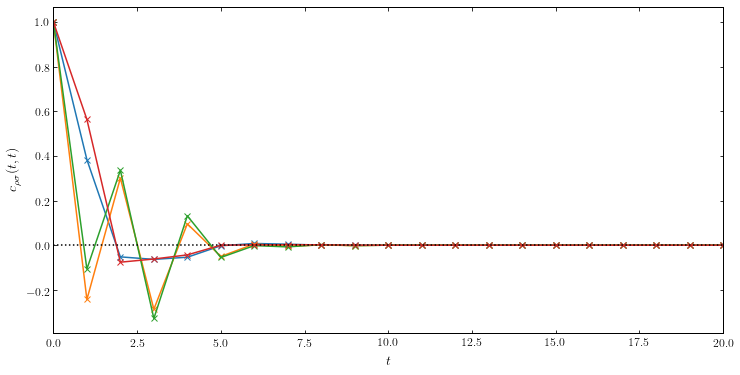

In [9]:
#Calculate correlations
n_t = 21

corr_range = np.zeros([n_obs,n_t],dtype=complex)
for i,sigma_i in enumerate(sigma):
    corr_range[i,:] = corr(U, rho, sigma_i, n_t)
    
#Plot correlations
fig, ax = plt.subplots(figsize=[12,6])
for i in range(n_obs):
    ax.plot(np.arange(n_t),corr_range[i,:].real,'x-')

#Ergodic value
ax.axhline(0.,color='k',linestyle=':')

ax.set_xlim([0,n_t-1])
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$c_{\rho \sigma}(t,t)$')
plt.show()

### Ergodic and non-mixing gates

Ergodic and non-mixing dual-unitary gates can be constructed, where all correlations oscillate with a period $q$ around the zero ergodic value. These are realized by choosing the single-site unitaries in such a way that the quantum channel acts as a shift operator on the diagonal matrices, mapping $e_{a,a}$ to $e_{a+1,a+1}$, after which a general unitary transformation $w$ leaves the eigenvalues invariant.

\begin{equation*}
P_{a,b} = e^{i \theta_a} \delta_{a,a+1} \qquad \Rightarrow \qquad u = w P, \qquad v = w^{\dagger},
\end{equation*}

with  $w \in SU(q)$ and in which $P$ and $\theta_{a}, a =1\dots q$ are arbitrary phases. 

The quantum channel $\mathcal{M}$ should have $q$ eigenvalues corresponding to the $q$ roots of unity $e^{2\pi i f/q}, f=1\dots q$.

In [10]:
#Generate ergodic and non-mixing gate

#J can take arbitrary values
J = 2.*np.pi*np.random.rand(q,q)
V = VGate(J)

#Define shift operator
P = np.zeros([q,q],dtype=complex)
theta = np.random.rand(q)
for a in range(q):
    P[a,(a+1) % q] = np.exp(1j*theta[a]) 

#Additional unitary transformation
w = unitary_group.rvs(q)

#Add one-site unitaries to each leg
u_plus = w @ P 
v_plus = np.conj(w.T)

u_min = unitary_group.rvs(q)
v_min = unitary_group.rvs(q)

#Construct u with random block-diagonal matrices on relevant opposing legs
U = np.einsum('ae,bf,efgh,gc,hd-> abcd' ,u_plus, u_min, V, v_min, v_plus)

#Verify unitarity and dual unitarity
#Check unitarity of U
print("Check unitarity: ||U * U^{\dag}-1|| = ", np.linalg.norm(np.einsum('abcd,efcd -> abef', U, np.conj(U))-IdId))
print("Check unitarity: ||U^{\dag} * U-1|| = ", np.linalg.norm(np.einsum('cdab,cdef -> abef', np.conj(U), U)-IdId))

#Check dual unitarity of U
print("Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| = ",
      np.linalg.norm(np.einsum('fbea,fdec->abcd',np.conj(U),U)-IdId))
print("Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| = ",
      np.linalg.norm(np.einsum('bfae,dfce->abcd',np.conj(U),U)-IdId))

#Check eigenvalues of quantum channel
M = np.einsum('cfea,dfeb -> abcd',np.conj(U),U) / q
[eig_vals,_] = np.linalg.eig(tensor_to_matrix(M))
print("Eigenvalues of M:", eig_vals[np.argsort(np.abs(eig_vals))])
print("|Eigenvalues of M|:", np.sort(np.abs(eig_vals)))
#print("Roots of unity eigenvalues:",[np.exp(-1j*2.*np.pi*i/q)for i in range(q)])

Check unitarity: ||U * U^{\dag}-1|| =  6.3131126833124404e-15
Check unitarity: ||U^{\dag} * U-1|| =  6.22652305167641e-15
Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| =  6.19066135229847e-15
Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| =  6.322378140159715e-15
Eigenvalues of M: [ 3.8953e-01+2.1391e-01j -2.1391e-01-3.8953e-01j  2.1391e-01-3.8953e-01j
  3.8953e-01-2.1391e-01j -2.1391e-01+3.8953e-01j -3.8953e-01-2.1391e-01j
  2.1391e-01+3.8953e-01j -3.8953e-01+2.1391e-01j  9.6271e-17+5.0087e-01j
  2.2340e-17-5.0087e-01j -5.0087e-01+2.4021e-16j  5.0087e-01-2.1278e-16j
 -1.0000e+00-1.1102e-16j  3.6050e-16-1.0000e+00j  4.6144e-16+1.0000e+00j
  1.0000e+00-7.8086e-16j]
|Eigenvalues of M|: [0.4444 0.4444 0.4444 0.4444 0.4444 0.4444 0.4444 0.4444 0.5009 0.5009
 0.5009 0.5009 1.     1.     1.     1.    ]


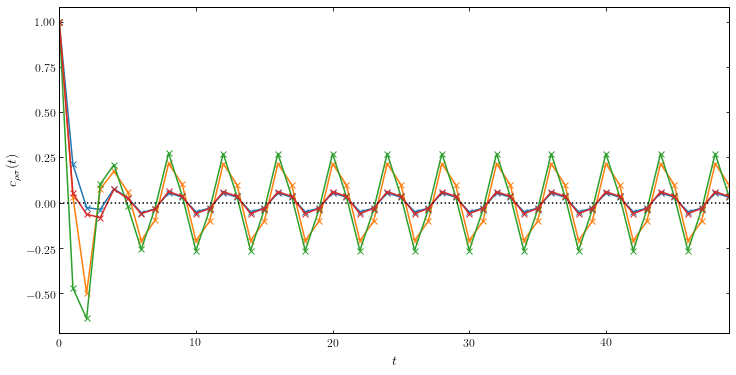

In [11]:
#Calculate correlations
n_t = 50

corr_range = np.zeros([n_obs,n_t],dtype=complex)
for i,sigma_i in enumerate(sigma):
    corr_range[i,:] = corr(U, rho, sigma_i, n_t)
    
#Plot correlations
fig, ax = plt.subplots(figsize=[12,6])
for i in range(n_obs):
    ax.plot(np.arange(n_t),corr_range[i,:].real,'x-')

#Ergodic value
ax.axhline(0.,color='k',linestyle=':')

ax.set_xlim([0,n_t-1])
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$c_{\rho \sigma}(t)$')
plt.show()

### Non-ergodic gates

Non-ergodic gates where the quantum channel has $1 \leq n < q$ nontrivial eigenvalues one can be achieved by setting

\begin{equation*}
u = w \left[ 
\begin{array}{c|c} 
  {1}_n & 0 \\ 
  \hline 
  0 & u_{q-n} 
\end{array} 
\right] , \qquad v =\left[ 
\begin{array}{c|c} 
  {1}_n & 0 \\ 
  \hline 
  0 & v_{q-n} 
\end{array} 
\right] w^{\dagger},
\end{equation*}

in which $u_{q-n},v_{q-n} \in SU(q-n)$ and $w \in SU(q)$.

In [12]:
#Generate non-ergodic and mixing gate
n = 1

#J can take arbitrary values
J = 2.*np.pi*np.random.rand(q,q)
V = VGate(J)

#Block-diagonal legs
w = unitary_group.rvs(q)
u_plus = w @ np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) 
v_plus = np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) @ np.conj(w.T)

#Random legs
u_min = unitary_group.rvs(q)
v_min = unitary_group.rvs(q)

#Construct u with random block-diagonal matrices on relevant opposing legs
U = np.einsum('ae,bf,efgh,gc,hd-> abcd' ,u_plus, u_min, V, v_min, v_plus)

#Verify unitarity and dual unitarity
#Check unitarity of U
print("Check unitarity: ||U * U^{\dag}-1|| = ", np.linalg.norm(np.einsum('abcd,efcd -> abef', U, np.conj(U))-IdId))
print("Check unitarity: ||U^{\dag} * U-1|| = ", np.linalg.norm(np.einsum('cdab,cdef -> abef', np.conj(U), U)-IdId))

#Check dual unitarity of U
print("Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| = ",
      np.linalg.norm(np.einsum('fbea,fdec->abcd',np.conj(U),U)-IdId))
print("Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| = ",
      np.linalg.norm(np.einsum('bfae,dfce->abcd',np.conj(U),U)-IdId))

#Check eigenvalues of quantum channel
M = np.einsum('cfea,dfeb -> abcd',np.conj(U),U) / q
[eig_vals,_] = np.linalg.eig(tensor_to_matrix(M))
print("Eigenvalues of M:", eig_vals[np.argsort(np.abs(eig_vals))])

Check unitarity: ||U * U^{\dag}-1|| =  4.617694761178889e-15
Check unitarity: ||U^{\dag} * U-1|| =  4.617319540399151e-15
Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| =  4.654776790913455e-15
Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| =  4.743824286201657e-15
Eigenvalues of M: [ 0.1352+2.8491e-16j  0.0872-1.5918e-01j  0.0872+1.5918e-01j
  0.0795+3.3252e-01j  0.0795-3.3252e-01j -0.3023+2.0637e-01j
 -0.3023-2.0637e-01j  0.46  -1.4021e-01j  0.46  +1.4021e-01j
 -0.5257-2.0436e-01j -0.5257+2.0436e-01j -0.3265-4.7320e-01j
 -0.3265+4.7320e-01j  0.7477-1.2460e-16j  1.    +5.5376e-17j
  1.    +2.0817e-17j]


The steady-state value for $\mathcal{M}^t(\rho)$ can be written as

\begin{equation*}
\lim_{t \to \infty} \mathcal{M}^t(\rho) = \exp\left[\sum_{a=1}^n (\mu_a-\mu) c_a + \mu 1\right] = \rho_{\textrm{GGE}},
\end{equation*}

provided

\begin{equation*}
\mu_a = \ln \left(\mathrm{Tr}(\rho c_a )\right),\quad \mu =  \ln\left( \frac{1-\sum_{b=1}^n \mathrm{Tr}(\rho c_b )}{q-n}\right),
\end{equation*}

such that all long-time correlations are set by the GGE value as $\mathrm{Tr}\left[\rho_{GGE}\sigma\right]$.

In [13]:
#Construct GGE for initial rho
def c_a(a):
    mat = np.zeros([q,q],dtype=complex)
    mat[a,a] = 1.
    return w @ mat @ np.conj(w.T)

rho_exp = np.zeros([q,q],dtype=complex)
mu = np.log((1.-np.sum([np.trace(rho @ c_a(a)) for a in range(n)]))/(q-n))
for a in range(n):
    rho_exp += (np.log(np.trace(rho @ c_a(a)))-mu)*c_a(a)
rho_exp += mu * np.eye(q)
rho_GGE = expm(rho_exp)

#Compare with steady-state value of rho
M_mat = tensor_to_matrix(np.einsum('cfea,dfeb -> abcd',np.conj(U),U) / q)
M_inf = np.linalg.matrix_power(M_mat, 1000).reshape([q,q,q,q])

rho_ss = np.einsum('abcd,cd->ab',M_inf,rho)

print("Comparing steady-state rho to GGE rho")
print("||rho_{ss} - rho_{GGE}|| = ",np.linalg.norm(rho_ss-rho_GGE))

Comparing steady-state rho to GGE rho
||rho_{ss} - rho_{GGE}|| =  4.2798272451891977e-13


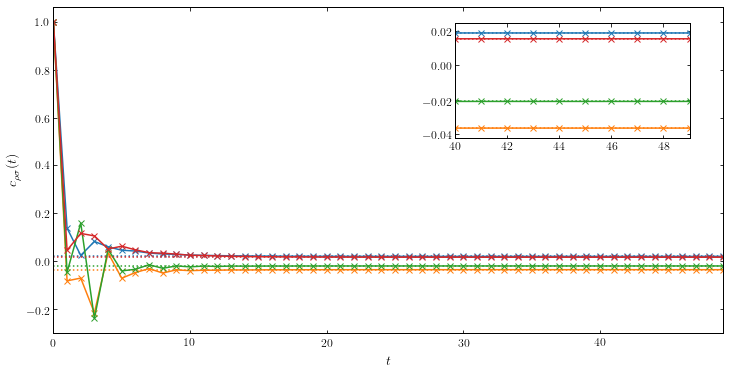

In [14]:
#Calculate correlations
n_t = 50

corr_range = np.zeros([n_obs,n_t],dtype=complex)
for i,sigma_i in enumerate(sigma):
    corr_range[i,:] = corr(U, rho, sigma_i, n_t)
    
#Plot correlations
fig, ax = plt.subplots(figsize=[12,6])
axins = ax.inset_axes([0.6,0.6,0.35,0.35])
for i in range(n_obs):
    ax.plot(np.arange(n_t),corr_range[i,:].real,'C%sx-'%i)
    ax.plot(np.arange(n_t),[np.trace(rho_GGE @ sigma[i]).real]*n_t,'C%s:'%i)
    axins.plot(np.arange(n_t),corr_range[i,:].real,'C%sx-'%i)
    axins.plot(np.arange(n_t),[np.trace(rho_GGE @ sigma[i]).real]*n_t,'C%s:'%i)

#Limits inset
corr_min = np.min([np.trace(rho_GGE @ sigma_).real for sigma_ in sigma])
corr_max = np.max([np.trace(rho_GGE @ sigma_).real for sigma_ in sigma])
axins.set_xlim([n_t-10,n_t-1])
axins.set_ylim(corr_min - 0.1*(corr_max-corr_min),corr_max + 0.1*(corr_max-corr_min))

ax.set_xlim([0,n_t-1])
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$c_{\rho \sigma}(t)$')
plt.show()

### Non-ergodic with $n>q$ dominant eigenvalues

Additional unit eigenvalues can be obtained by setting rows of $J$ to be equal up to a constant $\phi$, which will return oscillations of the form $e^{i\phi t}$ around the GGE value in the resulting correlations.

In [15]:
#Generate non-ergodic and possibly non-mixing gate
n = 2
phases = [0.3*np.pi]
m = len(phases)

#Construct V
J = 2.*np.pi*np.random.rand(q,q)

#Set rows of J to be equal up to a possible phase shift
for i in range(m):
    J[2*i+1,:] = J[2*i,:]+phases[i]
    
V = VGate(J)

#Block-diagonal legs
w = unitary_group.rvs(q)
u_plus = w @ np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) 
v_plus = np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) @ np.conj(w.T)

#Random legs
u_min = unitary_group.rvs(q)
v_min = unitary_group.rvs(q)

#Construct u with random block-diagonal matrices on relevant opposing legs
U = np.einsum('ae,bf,efgh,gc,hd-> abcd' ,u_plus, u_min, V, v_min, v_plus)

#Verify unitarity and dual unitarity
#Check unitarity of U
print("Check unitarity: ||U * U^{\dag}-1|| = ", np.linalg.norm(np.einsum('abcd,efcd -> abef', U, np.conj(U))-IdId))
print("Check unitarity: ||U^{\dag} * U-1|| = ", np.linalg.norm(np.einsum('cdab,cdef -> abef', np.conj(U), U)-IdId))

#Check dual unitarity of U
print("Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| = ",
      np.linalg.norm(np.einsum('fbea,fdec->abcd',np.conj(U),U)-IdId))
print("Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| = ",
      np.linalg.norm(np.einsum('bfae,dfce->abcd',np.conj(U),U)-IdId))

#Check eigenvalues of quantum channel
M = np.einsum('cfea,dfeb -> abcd',np.conj(U),U) / q
[eig_vals,_] = np.linalg.eig(tensor_to_matrix(M))
print("Eigenvalues of M:", eig_vals[np.argsort(np.abs(eig_vals))])

Check unitarity: ||U * U^{\dag}-1|| =  3.372198700310315e-15
Check unitarity: ||U^{\dag} * U-1|| =  3.4606302259291255e-15
Check dual unitarity: ||tilde{U} * tilde{U}^{\dag} - 1|| =  3.3597097096296933e-15
Check dual unitarity: ||tilde{U}^{\dag} * tilde{U} - 1|| =  3.423606850040638e-15
Eigenvalues of M: [-0.1457+5.7972e-01j  0.3834-4.5860e-01j -0.1457-5.7972e-01j
  0.3834+4.5860e-01j -0.4787+3.7285e-01j -0.4787-3.7285e-01j
  0.6123-2.9284e-16j -0.2404-5.7917e-01j  0.3272-5.3493e-01j
  0.3272+5.3493e-01j -0.2404+5.7917e-01j  0.5878+8.0902e-01j
  1.    +1.9082e-17j  1.    +1.1102e-16j  0.5878-8.0902e-01j
  1.    -6.9389e-18j]


In [16]:
#Construct GGE for initial rho
def c_a(a):
    mat = np.zeros([q,q],dtype=complex)
    mat[a,a] = 1.
    return w @ mat @ np.conj(w.T)

rho_exp = np.zeros([q,q],dtype=complex)
mu = np.log((1.-np.sum([np.trace(rho @ c_a(a)) for a in range(n)]))/(q-n))
for a in range(n):
    rho_exp += (np.log(np.trace(rho @ c_a(a)))-mu)*c_a(a)
rho_exp += mu * np.eye(q)
rho_GGE = expm(rho_exp)

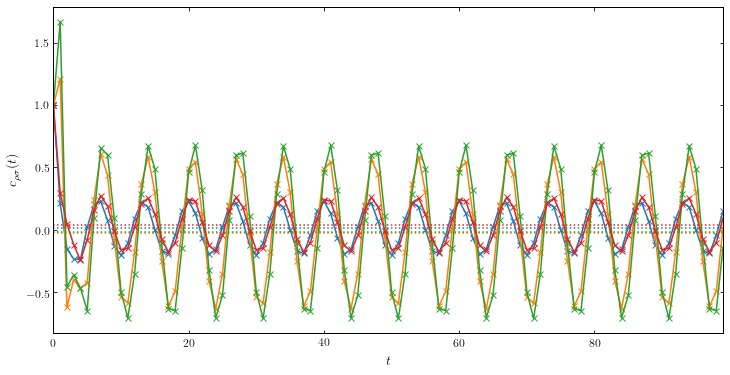

In [17]:
#Calculate correlations
n_t = 100

corr_range = np.zeros([n_obs,n_t],dtype=complex)
for i,sigma_i in enumerate(sigma):
    corr_range[i,:] = corr(U, rho, sigma_i, n_t)
    
#Plot correlations
fig, ax = plt.subplots(figsize=[12,6])
for i in range(n_obs):
    ax.plot(np.arange(n_t),corr_range[i,:].real,'C%sx-'%i)
    ax.plot(np.arange(n_t),[np.trace(rho_GGE @ sigma[i]).real]*n_t,'C%s:'%i)

ax.set_xlim([0,n_t-1])
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$c_{\rho \sigma}(t)$')
plt.show()

## Prethermalization

We can introduce a small ergodicity-inducing perturbation on top of a non-ergodic model starting by setting

\begin{align*}
u =  e^{i \epsilon W_u}  w \left[ 
\begin{array}{c|c} 
  {1}_n & 0 \\ 
  \hline 
  0 & u_{q-n} 
\end{array} 
\right],\,
v = \left[ 
\begin{array}{c|c} 
  {1}_n & 0 \\ 
  \hline 
  0 & v_{q-n} 
\end{array} 
\right]w^{\dagger}  e^{-i \epsilon W_v},
\end{align*}

with again $u_{q-n},v_{q-n} \in SU(q-n)$, $w \in SU(q)$, and where the perturbation is generated by two (non-equal) Hermitian operators $W_{u,v} \in {C}^{q\times q}$ and can be tuned through $\epsilon$. At $\epsilon=0$, this reduces to a non-ergodic model with $n$ conservation laws, whereas any finite $\epsilon$ results in an ergodic model with all nontrivial eigenvalues of the quantum channel having a modulus smaller than one. 

This leads to a separation of time scales in the correlations, where the system initially reaches the GGE value associated with the non-ergodic gate, before thermalizing to the ergodic value after a time scale $\propto \epsilon^{-2}$ set by the dominant eigenvalue of the quantum channel.

In [18]:
#Generate non-ergodic gate with additional perturbation
n = 2

#Range of perturbation strengths epsilon
eps_range = 10**np.arange(-3.,-1.,0.5)

#J can take arbitrary values
J = 2.*np.pi*np.random.rand(q,q)
V = VGate(J)

#Ergodicity-inducing terms mixing all operators
h_min = np.random.rand(q,q) + 1j*np.random.rand(q,q) 
h_min = 0.5*(h_min+np.conj(h_min).T)
g_min = np.random.rand(q,q)+ 1j*np.random.rand(q,q) 
g_min = 0.5*(g_min+np.conj(g_min).T)


#Block-diagonal legs
w = unitary_group.rvs(q)
u_plus = w @ np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) 
v_plus = np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) @ np.conj(w.T)

#Random legs
u_min = unitary_group.rvs(q)
v_min = unitary_group.rvs(q)

#Non-ergodic gate
U_ne = np.einsum('ae,bf,efgh,gc,hd-> abcd',u_plus, u_min, V, v_min, v_plus)

#Ergodic gates
U_eps = ([np.einsum('ae,ebcf,fd->abcd', expm(1j*eps_i*g_min) ,U_ne, expm(1j*eps_i*h_min))
                      for eps_i in eps_range])

#Construct u with random block-diagonal matrices on relevant opposing legs
U = np.einsum('ae,bf,efgh,gc,hd-> abcd' ,u_plus, u_min, V, v_min, v_plus)

In [19]:
#Construct GGE for initial rho
def c_a(a):
    mat = np.zeros([q,q],dtype=complex)
    mat[a,a] = 1.
    return w @ mat @ np.conj(w.T)

rho_exp = np.zeros([q,q],dtype=complex)
mu = np.log((1.-np.sum([np.trace(rho @ c_a(a)) for a in range(n)]))/(q-n))
for a in range(n):
    rho_exp += (np.log(np.trace(rho @ c_a(a)))-mu)*c_a(a)
rho_exp += mu * np.eye(q)
rho_GGE = expm(rho_exp)

In [20]:
#Check eigenvalues of quantum channel
tau = np.zeros(len(eps_range))
for i, U_i in enumerate(U_eps):
    M = np.einsum('cfea,dfeb -> abcd',np.conj(U_i),U_i) / q
    [eig_vals,_] = np.linalg.eig(tensor_to_matrix(M))
    tau[i] = 1./(1.-np.sort(np.abs(eig_vals))[-2])
print("Thermalization times:", tau)
print("epsilon range:",eps_range)

Thermalization times: [493587.3866  49365.351    4939.3702    495.5131]
epsilon range: [0.001  0.0032 0.01   0.0316]


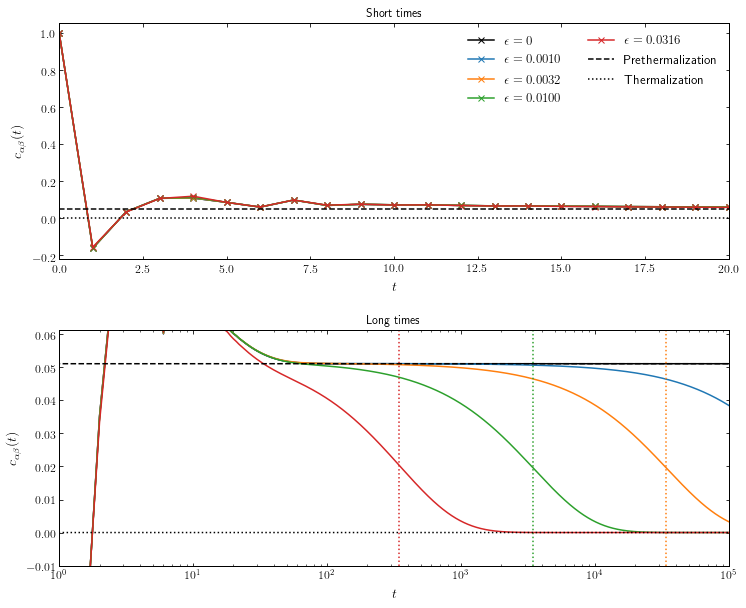

In [21]:
#Calculate correlations
n_t = 100000
sigma_ = sigma[0]


corr_ne = corr(U_ne, rho, sigma_, n_t)
corr_range = np.zeros([len(eps_range),n_t],dtype=complex)
for i, U_i in enumerate(U_eps):
    corr_range[i,:] = corr(U_i, rho, sigma_, n_t)
    

fig, [ax1,ax2] = plt.subplots(2,1,figsize=[12,10])

ax1.plot(np.arange(n_t), corr_ne.real, 'kx-',label=r'$\epsilon = 0$')
ax2.semilogx(np.arange(n_t), corr_ne.real, 'k-',label=r'$\epsilon = 0$')

for i in range(len(eps_range)):
    ax1.plot(np.arange(n_t), corr_range[i,:].real, 'C%sx-'%i,label=r'$\epsilon = %.4f$'%eps_range[i])
    ax2.semilogx(np.arange(n_t), corr_range[i,:].real, 'C%s-'%i,label=r'$\epsilon = %.4f$'%eps_range[i])
    ax2.axvline(np.log(2.)*tau[i],color='C%s'%i,linestyle=':')
    
ax1.set_xlim([0,20])
ax2.set_xlim([1,n_t-1])

ax1.set_title(r'Short times')
ax2.set_title(r'Long times')
for ax in [ax1,ax2]:
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$c_{\alpha \beta}(t)$')
    ax.plot(np.arange(n_t),[np.trace(rho_GGE @ sigma_).real]*n_t,'k--',label=r'Prethermalization')
    ax.plot(np.arange(n_t),[0.]*n_t,'k:',label=r'Thermalization')
    
ax1.legend(ncol=2)
ax2.set_ylim([-0.2*np.trace(rho_GGE @ sigma_).real, 1.2*np.trace(rho_GGE @ sigma_).real])    
plt.subplots_adjust(hspace = .3)
plt.show()

### Level statistics

We can also verify level spacing ratios. Given the eigenspectrum $e^{i\theta_n}$, with $\theta_n$ sorted, of the unitary evolution operator, the average level spacing ratio is defined as the average value of

\begin{equation*}
r_n = \frac{\textrm{min}(s_n,s_{n+1})}{\textrm{max}(s_n,s_{n+1})}, \qquad s_n = \theta_{n+1}-\theta_{n}.
\end{equation*}

For an ergodic circuit we expect $\langle r \rangle = 0.600$, reproducing the GUE value, whereas a non-ergodic circuit should lead to Poissonian statistics and $\langle r \rangle = 0.386$.

In the following, we will consider a circuit with periodic boundary conditions, consisting of two layers of 3 circuits each. The individual gates are drawn from a distribution with a given level of ergodicity such that we break translational invariance. This is a relatively small system of 6 sites, but already sufficient to draw conclusions. The total number of eigenvalues is given by $q^{6}$.

In [22]:
def DualUnitary_Erg(q):    
    #Entangling part
    J = 2.*np.pi*np.random.rand(q,q)
    V = np.zeros([q,q,q,q],dtype=complex)
    for a in range(q):
        for b in range(q):
            V[a,b,b,a] = np.exp(1j*J[a,b]) 
    
    #Add random unitary element to each leg
    u_plus = unitary_group.rvs(q)
    u_min = unitary_group.rvs(q)
    v_plus = unitary_group.rvs(q)
    v_min = unitary_group.rvs(q)
    
    U = np.einsum('ac,bd,cdef,eg,fh-> abgh' ,u_plus, u_min, V, v_plus, v_min)
    return(U)

#Sample circuits and calculate level spacing statistics with periodic boundary conditions
print("Sampling ergodic and mixing circuits.")
q = 4
U_s = [DualUnitary_Erg(q) for i in range(6)]

U_1 = tensor_to_matrix(np.einsum('ghab,ijcd,klef -> abcdefghijkl',U_s[0],U_s[1],U_s[2]))
U_2 = tensor_to_matrix(np.einsum('hibc,jkde,lgfa -> abcdefghijkl',U_s[3],U_s[4],U_s[5]))
U_tot = U_2 @ U_1
[eig_vals,_] = np.linalg.eig(U_tot)
theta = np.sort((-1j*np.log(eig_vals)).real)
s = theta[1:-1] - theta[0:-2]
r = [min(s[i],s[i+1])/max(s[i],s[i+1]) for i in range(len(s)-1)]

#<r> = 0.600 for GUE matrices, <r> = 0.386 for Poisson statistics
print("<r> =", np.average(r), "calculated from", len(eig_vals), "eigenvalues")

Sampling ergodic and mixing circuits.
<r> = 0.6095856325922887 calculated from 4096 eigenvalues


In [23]:
#Sample non-ergodic circuits with same conserved charges
def DualUnitary_NonErg(q, n, w):    
    #Entangling part
    J = 2.*np.pi*np.random.rand(q,q)
    V = np.zeros([q,q,q,q],dtype=complex)
    for a in range(q):
        for b in range(q):
            V[a,b,b,a] = np.exp(1j*J[a,b]) 

    #Block-diagonal legs
    u_plus = w @ np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) 
    v_plus = np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) @ np.conj(w.T)

    #Random legs
    u_min = unitary_group.rvs(q)
    v_min = unitary_group.rvs(q)

    #Construct u with random block-diagonal matrices on relevant opposing legs
    U = np.einsum('ae,bf,efgh,gc,hd-> abcd' ,u_plus, u_min, V, v_min, v_plus)
    return U

#Sample circuits and calculate level spacing statistics with periodic boundary conditions
print("Sampling non-ergodic circuits.")
q, n = 4, 1
w = unitary_group.rvs(q)
U_s = [DualUnitary_NonErg(q, n, w) for i in range(6)]

U_1 = tensor_to_matrix(np.einsum('ghab,ijcd,klef -> abcdefghijkl',U_s[0],U_s[1],U_s[2]))
U_2 = tensor_to_matrix(np.einsum('hibc,jkde,lgfa -> abcdefghijkl',U_s[3],U_s[4],U_s[5]))
U_tot = U_2 @ U_1
[eig_vals,_] = np.linalg.eig(U_tot)
theta = np.sort((-1j*np.log(eig_vals)).real)
s = theta[1:-1] - theta[0:-2]
r = [min(s[i],s[i+1])/max(s[i],s[i+1]) for i in range(len(s)-1)]

#<r> = 0.600 for GUE matrices, <r> = 0.386 for Poisson statistics
print("<r> =", np.average(r), "calculated from", len(eig_vals), "eigenvalues")

Sampling non-ergodic circuits.
<r> = 0.4027003199210968 calculated from 4096 eigenvalues


In [24]:
#Sample ergodic and non-mixing circuits
def DualUnitary_Erg_NonMix(q, w):    
    J = 2.*np.pi*np.random.rand(q,q)
    V = VGate(J)

    #Define shift operator
    P = np.zeros([q,q],dtype=complex)
    theta = np.random.rand(q)
    for a in range(q):
        P[a,(a+1) % q] = np.exp(1j*theta[a]) 

    #Add one-site unitaries to each leg
    u_plus = w @ P 
    v_plus = np.conj(w.T)
    u_min = unitary_group.rvs(q)
    v_min = unitary_group.rvs(q)

    #Construct u with random block-diagonal matrices on relevant opposing legs
    U = np.einsum('ae,bf,efgh,gc,hd-> abcd' ,u_plus, u_min, V, v_min, v_plus)
    return(U)

#Sample circuits and calculate level spacing statistics with periodic boundary conditions
print("Sampling ergodic and non-mixing circuits.")
q = 4
w = unitary_group.rvs(q)
U_s = [DualUnitary_Erg_NonMix(q, w) for i in range(6)]

U_1 = tensor_to_matrix(np.einsum('ghab,ijcd,klef -> abcdefghijkl',U_s[0],U_s[1],U_s[2]))
U_2 = tensor_to_matrix(np.einsum('hibc,jkde,lgfa -> abcdefghijkl',U_s[3],U_s[4],U_s[5]))
U_tot = U_2 @ U_1
[eig_vals,_] = np.linalg.eig(U_tot)
theta = np.sort((-1j*np.log(eig_vals)).real)
s = theta[1:-1] - theta[0:-2]
r = [min(s[i],s[i+1])/max(s[i],s[i+1]) for i in range(len(s)-1)]

#<r> = 0.600 for GUE matrices, <r> = 0.386 for Poisson statistics
print("<r> =", np.average(r), "calculated from", len(eig_vals), "eigenvalues")

Sampling ergodic and non-mixing circuits.
<r> = 0.3722777759505331 calculated from 4096 eigenvalues


In [25]:
#Transition from non-ergodic to ergodic
#Generate non-ergodic gate with additional perturbation
q = 3
n = 1

#Ergodicity-inducing terms mixing all operators
h_min = np.random.rand(q,q) + 1j*np.random.rand(q,q) 
h_min = 0.5*(h_min+np.conj(h_min).T)
g_min = np.random.rand(q,q)+ 1j*np.random.rand(q,q) 
g_min = 0.5*(g_min+np.conj(g_min).T)

#Unitary transformation
w = unitary_group.rvs(q)

def Pretherm_Gate(q,n,w,h_min,g_min,eps):
    #J can take arbitrary values
    J = 2.*np.pi*np.random.rand(q,q)
    V = VGate(J)

    #Block-diagonal legs
    u_plus = w @ np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) 
    v_plus = np.block([[np.eye(n),np.zeros([n,q-n])],[np.zeros([q-n,n]),unitary_group.rvs(q-n)]]) @ np.conj(w.T)

    #Random legs
    u_min = unitary_group.rvs(q)
    v_min = unitary_group.rvs(q)
    #Non-ergodic gate
    U_ne = np.einsum('ae,bf,efgh,gc,hd-> abcd',u_plus, u_min, V, v_min, v_plus)
    #Ergodic gates
    return np.einsum('ae,ebcf,fd->abcd', expm(1j*eps*g_min) ,U_ne, expm(1j*eps*h_min))

#Range of perturbation strengths epsilon
eps_range = 10**np.arange(-4.5,1.5,0.5)
r_eps_range = np.zeros(len(eps_range))
for i, eps_i in enumerate(eps_range):
#Sample circuits and calculate level spacing statistics with periodic boundary conditions
    print("Sampling perturbed non-ergodic models.")
    U_s = [Pretherm_Gate(q, n, w, h_min, g_min, eps_i) for i in range(6)]
    U_1 = tensor_to_matrix(np.einsum('ghab,ijcd,klef -> abcdefghijkl',U_s[0],U_s[1],U_s[2]))
    U_2 = tensor_to_matrix(np.einsum('hibc,jkde,lgfa -> abcdefghijkl',U_s[3],U_s[4],U_s[5]))
    U_tot = U_2 @ U_1

    [eig_vals,_] = np.linalg.eig(U_tot)
    theta = np.sort((-1j*np.log(eig_vals)).real)
    s = theta[1:-1] - theta[0:-2]
    r = [min(s[j],s[j+1])/max(s[j],s[j+1]) for j in range(len(s)-1)]
    r_eps_range[i] = np.average(r)
    #<r> = 0.600 for GUE matrices, <r> = 0.386 for Poisson statistics
    print("<r> =", np.average(r), "calculated from", len(eig_vals), "eigenvalues for \epsilon = ", eps_i)


Sampling perturbed non-ergodic models.
<r> = 0.4235450091656533 calculated from 729 eigenvalues for \epsilon =  3.1622776601683795e-05
Sampling perturbed non-ergodic models.
<r> = 0.4106328041824178 calculated from 729 eigenvalues for \epsilon =  0.0001
Sampling perturbed non-ergodic models.
<r> = 0.3874331890337865 calculated from 729 eigenvalues for \epsilon =  0.00031622776601683794
Sampling perturbed non-ergodic models.
<r> = 0.41602363434944306 calculated from 729 eigenvalues for \epsilon =  0.001
Sampling perturbed non-ergodic models.
<r> = 0.43404496992533775 calculated from 729 eigenvalues for \epsilon =  0.0031622776601683794
Sampling perturbed non-ergodic models.
<r> = 0.49261837108236156 calculated from 729 eigenvalues for \epsilon =  0.01
Sampling perturbed non-ergodic models.
<r> = 0.5901756570814218 calculated from 729 eigenvalues for \epsilon =  0.03162277660168379
Sampling perturbed non-ergodic models.
<r> = 0.5993737084100791 calculated from 729 eigenvalues for \epsilo

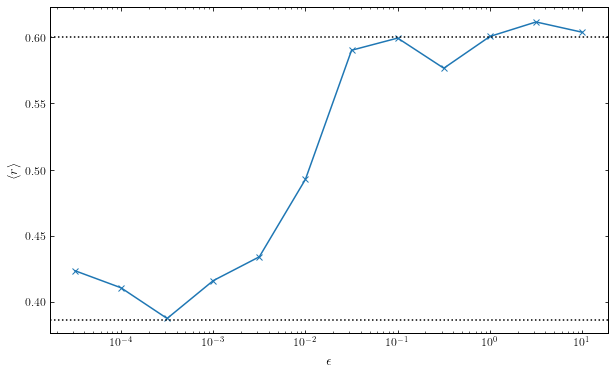

In [26]:
fig,ax = plt.subplots()
ax.semilogx(eps_range,r_eps_range,'x-')
ax.axhline(0.386,linestyle=':',color='k')
ax.axhline(0.600,linestyle=':',color='k')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\langle r \rangle$')
plt.show()